In [ ]:
#final using

Starting wavelet analysis...

Columns found in each file:
Rainfall: ['min', 'max', 'mean', 'date']
SM: ['min', 'max', 'mean', 'date', 'exd', 'sed', 'mod', 'normal or wet']
SMDI: ['min', 'max', 'mean', 'date', 'exd', 'sed', 'mod', 'normal or wet']
CDI: ['min', 'max', 'mean', 'date', 'Moderately_Dry', 'Severely_Dry', 'Extreamly_Dry', 'No_Drought']
DS: ['min', 'max', 'mean', 'date']

Merged dataset columns:
['min', 'max', 'mean', 'date', 'min_sm', 'max_sm', 'mean_sm', 'exd', 'sed', 'mod', 'normal or wet', 'min_smdi', 'max_smdi', 'mean_smdi', 'exd_smdi', 'sed_smdi', 'mod_smdi', 'normal or wet_smdi', 'min_cdi', 'max_cdi', 'mean_cdi', 'Moderately_Dry', 'Severely_Dry', 'Extreamly_Dry', 'No_Drought', 'min_ds', 'max_ds', 'mean_ds']
Could not find any match for ['rainfall', 'rain', 'precip', 'prcp'] in ['min', 'max', 'mean', 'min_sm', 'max_sm', 'mean_sm', 'exd', 'sed', 'mod', 'normal or wet', 'min_smdi', 'max_smdi', 'mean_smdi', 'exd_smdi', 'sed_smdi', 'mod_smdi', 'normal or wet_smdi', 'min_cdi'

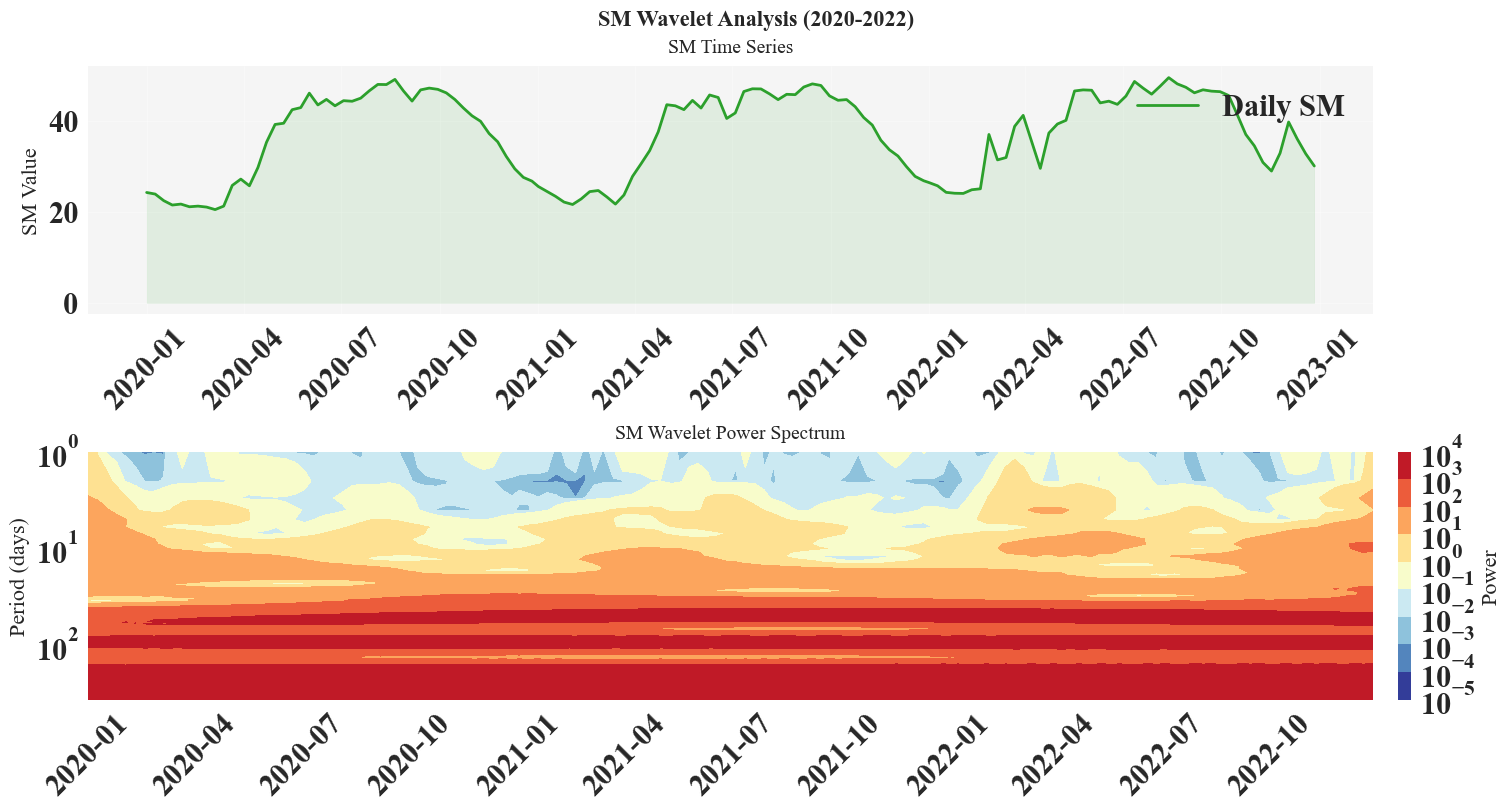

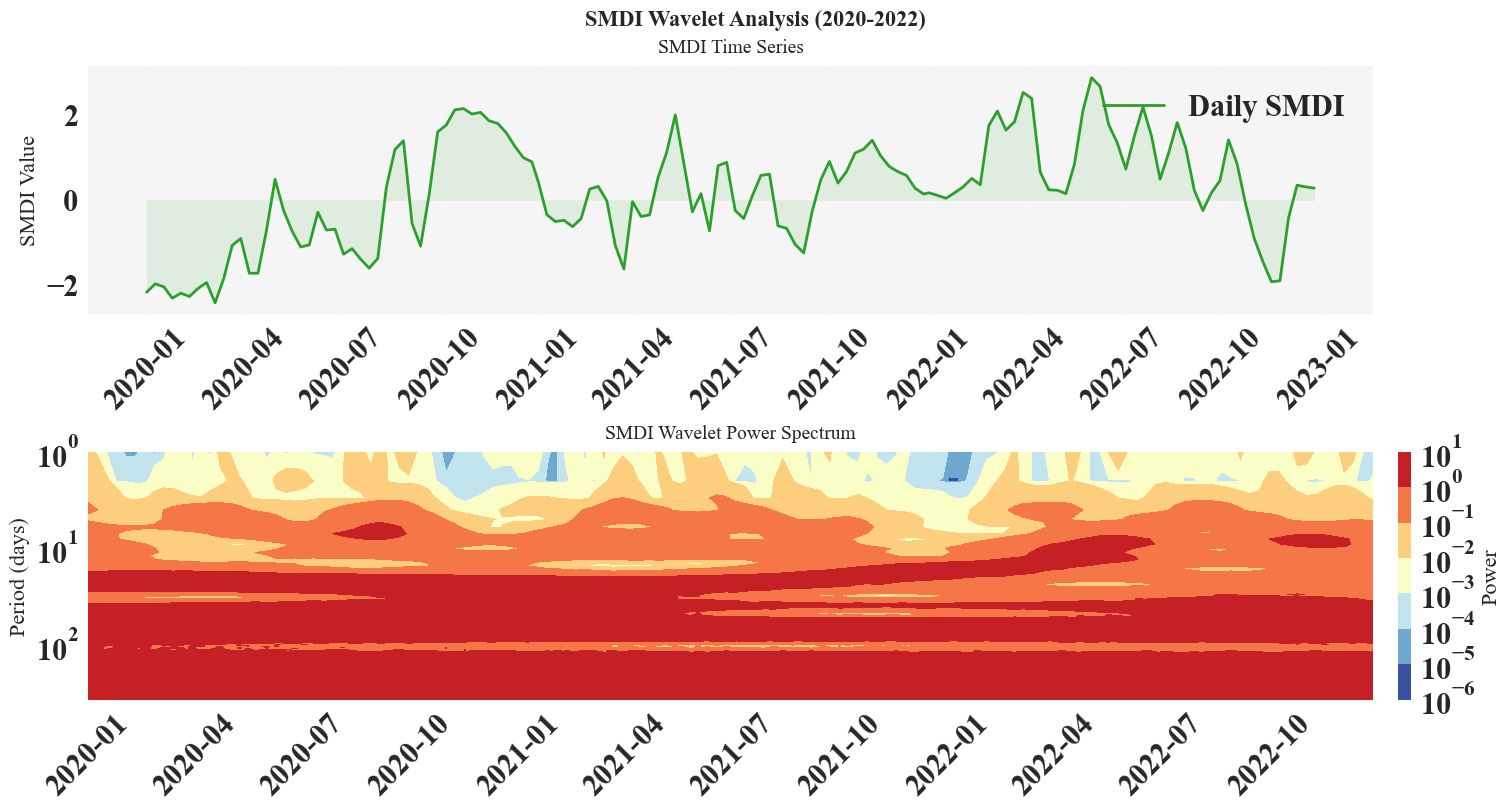

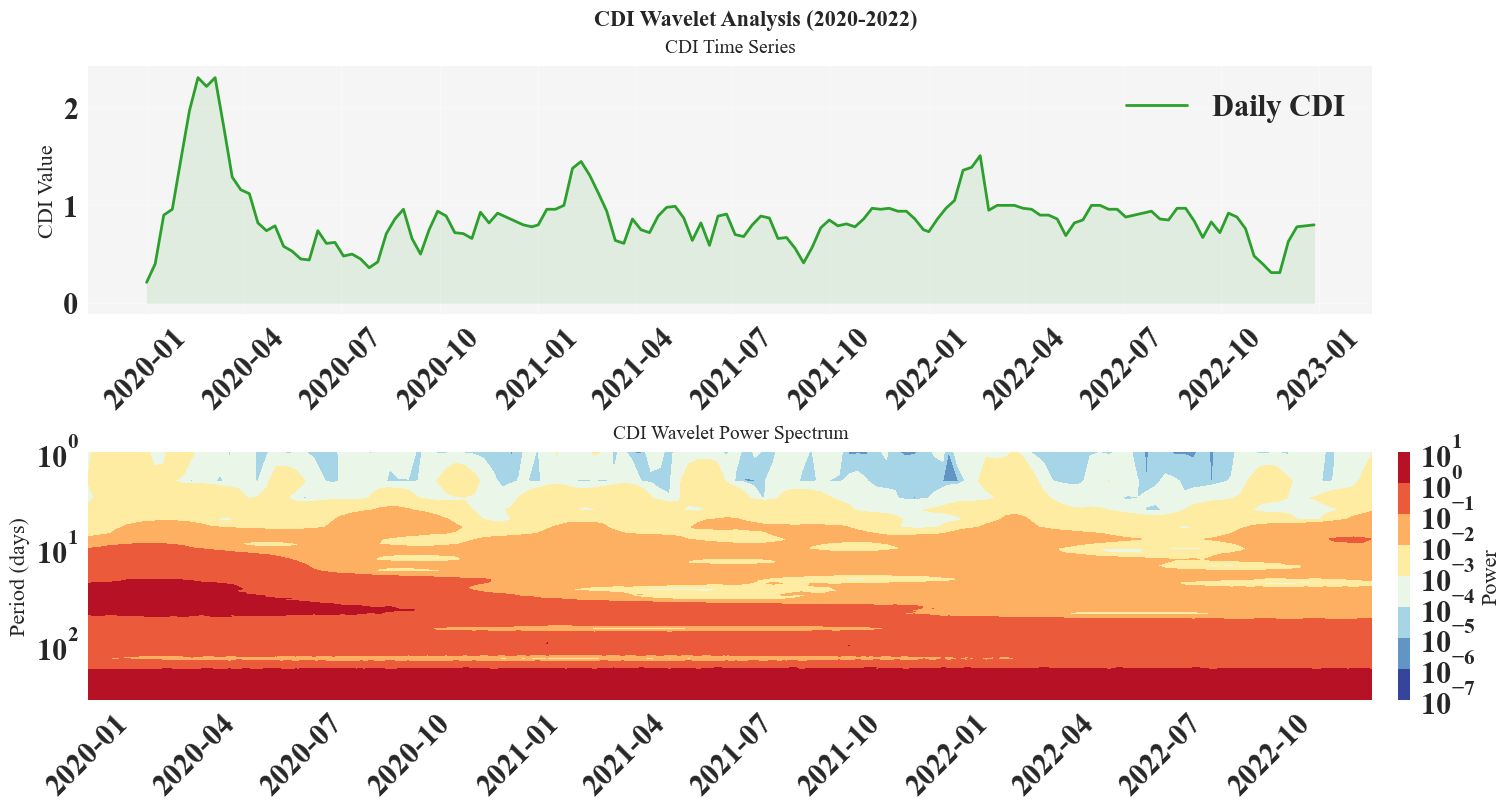

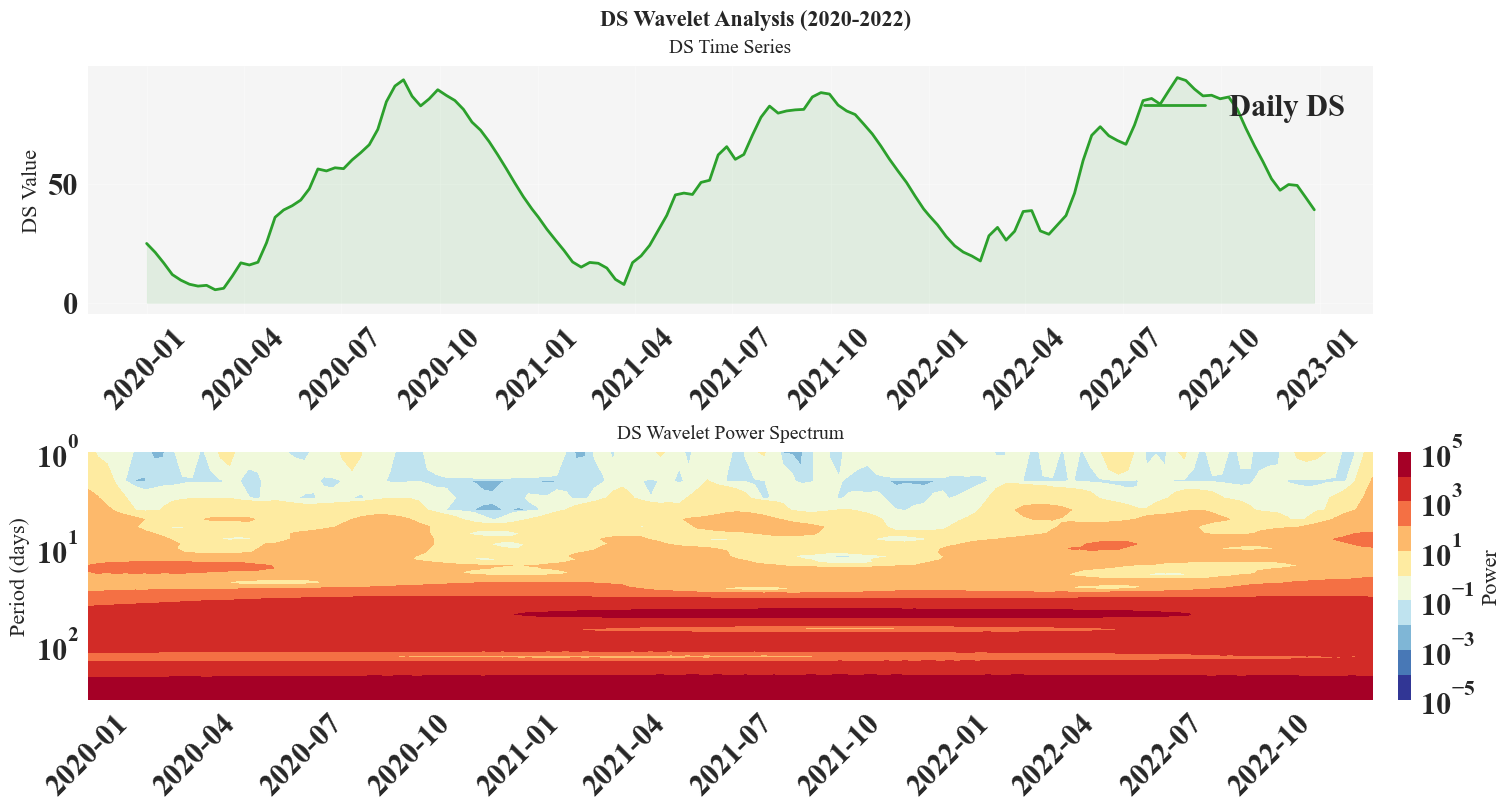

Analysis complete!


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import warnings
from matplotlib.dates import DateFormatter, MonthLocator
import seaborn as sns

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set global plotting style
plt.style.use('seaborn-v0_8')  # Modern style
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 22  # Set default font size
plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 22,
    'axes.titlesize': 22,
    'axes.labelsize': 22,
    'xtick.labelsize': 22,
    'ytick.labelsize': 22,
    'legend.fontsize': 22,
    'figure.titlesize': 22,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.facecolor': '#f5f5f5',
    'figure.facecolor': 'white'
})



def load_and_prepare_data():
    """Load and merge all data files with improved date handling."""
    try:
        # Dictionary to store all datasets
        data_dict = {
            'Rainfall': pd.read_csv('Rainfall.csv'),
            'SM': pd.read_csv('SM.csv'),
            'SMDI': pd.read_csv('SMDI.csv'),
            'CDI': pd.read_csv('CDI.csv'),
            'DS': pd.read_csv('DS.csv')
        }
        
        # Print column names for debugging
        print("\nColumns found in each file:")
        for name, df in data_dict.items():
            print(f"{name}: {list(df.columns)}")
        
        # Identify and convert date columns
        for name, df in data_dict.items():
            date_col = None
            for col in df.columns:
                if 'date' in col.lower() or 'time' in col.lower() or 'year' in col.lower():
                    date_col = col
                    break
            
            if date_col:
                try:
                    df['date'] = pd.to_datetime(df[date_col], errors='coerce')
                    df.dropna(subset=['date'], inplace=True)
                    df = df[(df['date'] > pd.Timestamp('1900-01-01')) & 
                           (df['date'] < pd.Timestamp('2100-01-01'))]
                except Exception as e:
                    print(f"Error converting dates in {name}: {e}")
            else:
                print(f"No date column found in {name}")
                return None
        
        # Merge all datasets
        merged = data_dict['Rainfall']
        for name, df in data_dict.items():
            if name != 'Rainfall':
                merged = merged.merge(df, on='date', how='inner', suffixes=('', f'_{name.lower()}'))
        
        if merged.empty:
            print("Merged dataset is empty - check date alignment")
            return None
        
        print("\nMerged dataset columns:")
        print(list(merged.columns))
        
        # Sort by date and ensure proper frequency
        merged = merged.sort_values('date')
        merged = merged.set_index('date')
        
        # Fill small gaps with interpolation
        for col in merged.columns:
            if merged[col].dtype in [np.float64, np.int64]:
                merged[col] = merged[col].interpolate(method='linear', limit=7)
            else:
                merged[col] = merged[col].fillna(method='ffill', limit=7)
        
        return merged
        
    except Exception as e:
        print(f"Error loading or merging data: {e}")
        return None

def find_column(columns, possible_names):
    """Find the best matching column name from a list of possible names."""
    columns = [str(col).strip().lower() for col in columns]
    for name in possible_names:
        for col in columns:
            if name.lower() in col:
                print(f"Matched: {col} -> {name}")
                return col
    print(f"Could not find any match for {possible_names} in {columns}")
    return None

def generate_statistics_table(merged, index_cols):
    """Generate a statistical summary table for the specified columns."""
    print("\nStatistical Summary of Key Metrics (2020-2022):")
    
    # Dictionary to store statistics
    stats_dict = {
        'Metric': [],
        'Mean': [],
        'Std Dev': [],
        'Min': [],
        'Q1': [],
        'Median': [],
        'Q3': [],
        'Max': [],
        'Unit': []
    }
    
    # Define units for each metric
    units = {
        'Rainfall': 'mm',
        'SM': '%',  # Assuming soil moisture is in percentage
        'SMDI': 'unitless',
        'CDI': 'unitless',
        'DS': 'unitless'
    }
    
    # Calculate statistics for each metric
    for name, col in index_cols.items():
        data = merged[col].dropna()  # Remove any remaining NaNs
        if not data.empty:
            stats_dict['Metric'].append(name)
            stats_dict['Mean'].append(round(data.mean(), 2))
            stats_dict['Std Dev'].append(round(data.std(), 2))
            stats_dict['Min'].append(round(data.min(), 2))
            stats_dict['Q1'].append(round(data.quantile(0.25), 2))
            stats_dict['Median'].append(round(data.median(), 2))
            stats_dict['Q3'].append(round(data.quantile(0.75), 2))
            stats_dict['Max'].append(round(data.max(), 2))
            stats_dict['Unit'].append(units[name])
    
    # Create a DataFrame for the statistics
    stats_df = pd.DataFrame(stats_dict)
    
    # Display the table
    print("\n" + "="*80)
    print(stats_df.to_string(index=False))
    print("="*80 + "\n")
    
    return stats_df

def perform_wavelet_analysis(merged):
    """Perform wavelet analysis with enhanced visualization."""
    if merged is None:
        return
    
    # Define the indices to analyze
    indices = {
        'Rainfall': ['rainfall', 'rain', 'precip', 'prcp'],
        'SM': ['soil moisture', 'sm', 'soil_moisture'],
        'SMDI': ['smdi', 'soil moisture drought index'],
        'CDI': ['cdi', 'composite drought index'],
        'DS': ['ds', 'drought severity']
    }
    
    # Find columns for each index
    index_cols = {}
    for name, possible_names in indices.items():
        col = find_column(merged.columns, possible_names)
        if col:
            print(f"Found column for {name}: {col}")
            index_cols[name] = col
        else:
            print(f"Warning: Column for {name} not found (tried: {possible_names})")
    
    if not index_cols:
        print("No valid columns found for analysis")
        return
    
    print("\nProceeding with analysis on these columns:")
    for name, col in index_cols.items():
        print(f"{name}: {col}")
    
    # Generate and display statistics table
    generate_statistics_table(merged, index_cols)
    
    # Prepare wavelet parameters
    scales = np.arange(1, 366)  # 1 day to 1 year
    wavelet = 'cmor1.5-1.0'  # Complex Morlet wavelet
    
    # Create Rainfall plot if available
    if 'Rainfall' in index_cols:
        print("\nCreating Rainfall wavelet analysis...")
        try:
            rainfall_data = merged[index_cols['Rainfall']].values
            dates = merged.index
            
            # Create figure for Rainfall analysis
            fig_rain = plt.figure(figsize=(15, 12), constrained_layout=True)
            fig_rain.suptitle('Rainfall Wavelet Analysis (2020-2022)', fontsize=16, weight='bold')
            
            # Time series plot
            ax1 = fig_rain.add_subplot(3, 1, 1)
            ax1.plot(dates, rainfall_data, color='#1f77b4', linewidth=2, label='Daily Rainfall')
            ax1.fill_between(dates, rainfall_data, alpha=0.1, color='#1f77b4')
            ax1.set_title('Rainfall Time Series', pad=10, fontsize=14)
            ax1.set_ylabel('Rainfall (mm)', fontsize=16)
            ax1.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
            ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
            ax1.tick_params(axis='x', rotation=45)
            ax1.legend(loc='upper right')
            
            # Wavelet power spectrum
            ax2 = fig_rain.add_subplot(3, 1, 2)
            coefficients, _ = pywt.cwt(rainfall_data, scales, wavelet, sampling_period=1)
            power = np.abs(coefficients)**2
            im = ax2.contourf(dates, scales, power, levels=100, cmap='RdYlBu_r',
                             norm=plt.matplotlib.colors.LogNorm(vmin=power.min()+1e-10, vmax=power.max()))
            ax2.set_title('Wavelet Power Spectrum', pad=10, fontsize=16)
            ax2.set_ylabel('Period (days)', fontsize=16)
            ax2.set_yscale('log')
            ax2.set_ylim(1, 365)
            ax2.invert_yaxis()
            ax2.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
            ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
            ax2.tick_params(axis='x', rotation=45)
            cbar = plt.colorbar(im, ax=ax2, label='Power', pad=0.02)
            cbar.set_label('Power', fontsize=16)
            
            # Global wavelet spectrum
            ax3 = fig_rain.add_subplot(3, 1, 3)
            global_ws = power.mean(axis=1)
            ax3.plot(global_ws, scales, color='#ff7f0e', linewidth=2)
            ax3.set_title('Global Wavelet Spectrum', pad=10, fontsize=16)
            ax3.set_xlabel('Power', fontsize=16)
            ax3.set_ylabel('Period (days)', fontsize=16)
            ax3.set_yscale('log')
            ax3.set_ylim(1, 365)
            ax3.invert_yaxis()
            ax3.grid(True, linestyle='--', alpha=0.7)
            
            plt.savefig('rainfall_wavelet_analysis.png', dpi=330, bbox_inches='tight')
            plt.show()
            
        except Exception as e:
            print(f"\nError in Rainfall wavelet analysis: {e}")
    
    # Create plots for other indices
    for name, col in index_cols.items():
        if name == 'Rainfall':
            continue

        try:
            data = merged[col].values
            
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8), constrained_layout=True)
            fig.suptitle(f'{name} Wavelet Analysis (2020-2022)', fontsize=16, weight='bold')
            
            # Time series plot
            ax1.plot(merged.index, data, color='#2ca02c', linewidth=2, label=f'Daily {name}')
            ax1.fill_between(merged.index, data, alpha=0.1, color='#2ca02c')
            ax1.set_title(f'{name} Time Series', pad=10, fontsize=14)
            ax1.set_ylabel(f'{name} Value', fontsize=16)
            ax1.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
            ax1.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
            ax1.tick_params(axis='x', rotation=45)
            ax1.legend(loc='upper right')
            
            # Wavelet power spectrum
            coefficients, _ = pywt.cwt(data, scales, wavelet, sampling_period=1)
            power = np.abs(coefficients)**2
            im = ax2.contourf(merged.index, scales, power, levels=100, cmap='RdYlBu_r',
                             norm=plt.matplotlib.colors.LogNorm(vmin=power.min()+1e-10, vmax=power.max()))
            ax2.set_title(f'{name} Wavelet Power Spectrum', pad=10, fontsize=14)
            ax2.set_ylabel('Period (days)', fontsize=16)
            ax2.set_yscale('log')
            ax2.set_ylim(1, 365)
            ax2.invert_yaxis()
            ax2.xaxis.set_major_locator(MonthLocator(bymonth=[1, 4, 7, 10]))
            ax2.xaxis.set_major_formatter(DateFormatter("%Y-%m"))
            ax2.tick_params(axis='x', rotation=45)
            cbar = plt.colorbar(im, ax=ax2, label='Power', pad=0.02)
            cbar.set_label('Power', fontsize=16)
            
            plt.savefig(f'{name}_wavelet_analysis.png', dpi=330, bbox_inches='tight')
            plt.show()
        
        except Exception as e:
            print(f"Wavelet analysis failed for {name}: {e}")

if __name__ == "__main__":
    print("Starting wavelet analysis...")
    merged_data = load_and_prepare_data()
    
    if merged_data is not None:
        perform_wavelet_analysis(merged_data)
    
    print("Analysis complete!")

In [ ]:
#continued analysis

Creating beautiful visualizations...
Created beautiful wavelet visualization: beautiful_wavelet_analysis.png
Created beautiful correlation heatmap: beautiful_correlation_heatmap.png
All visualizations created successfully!


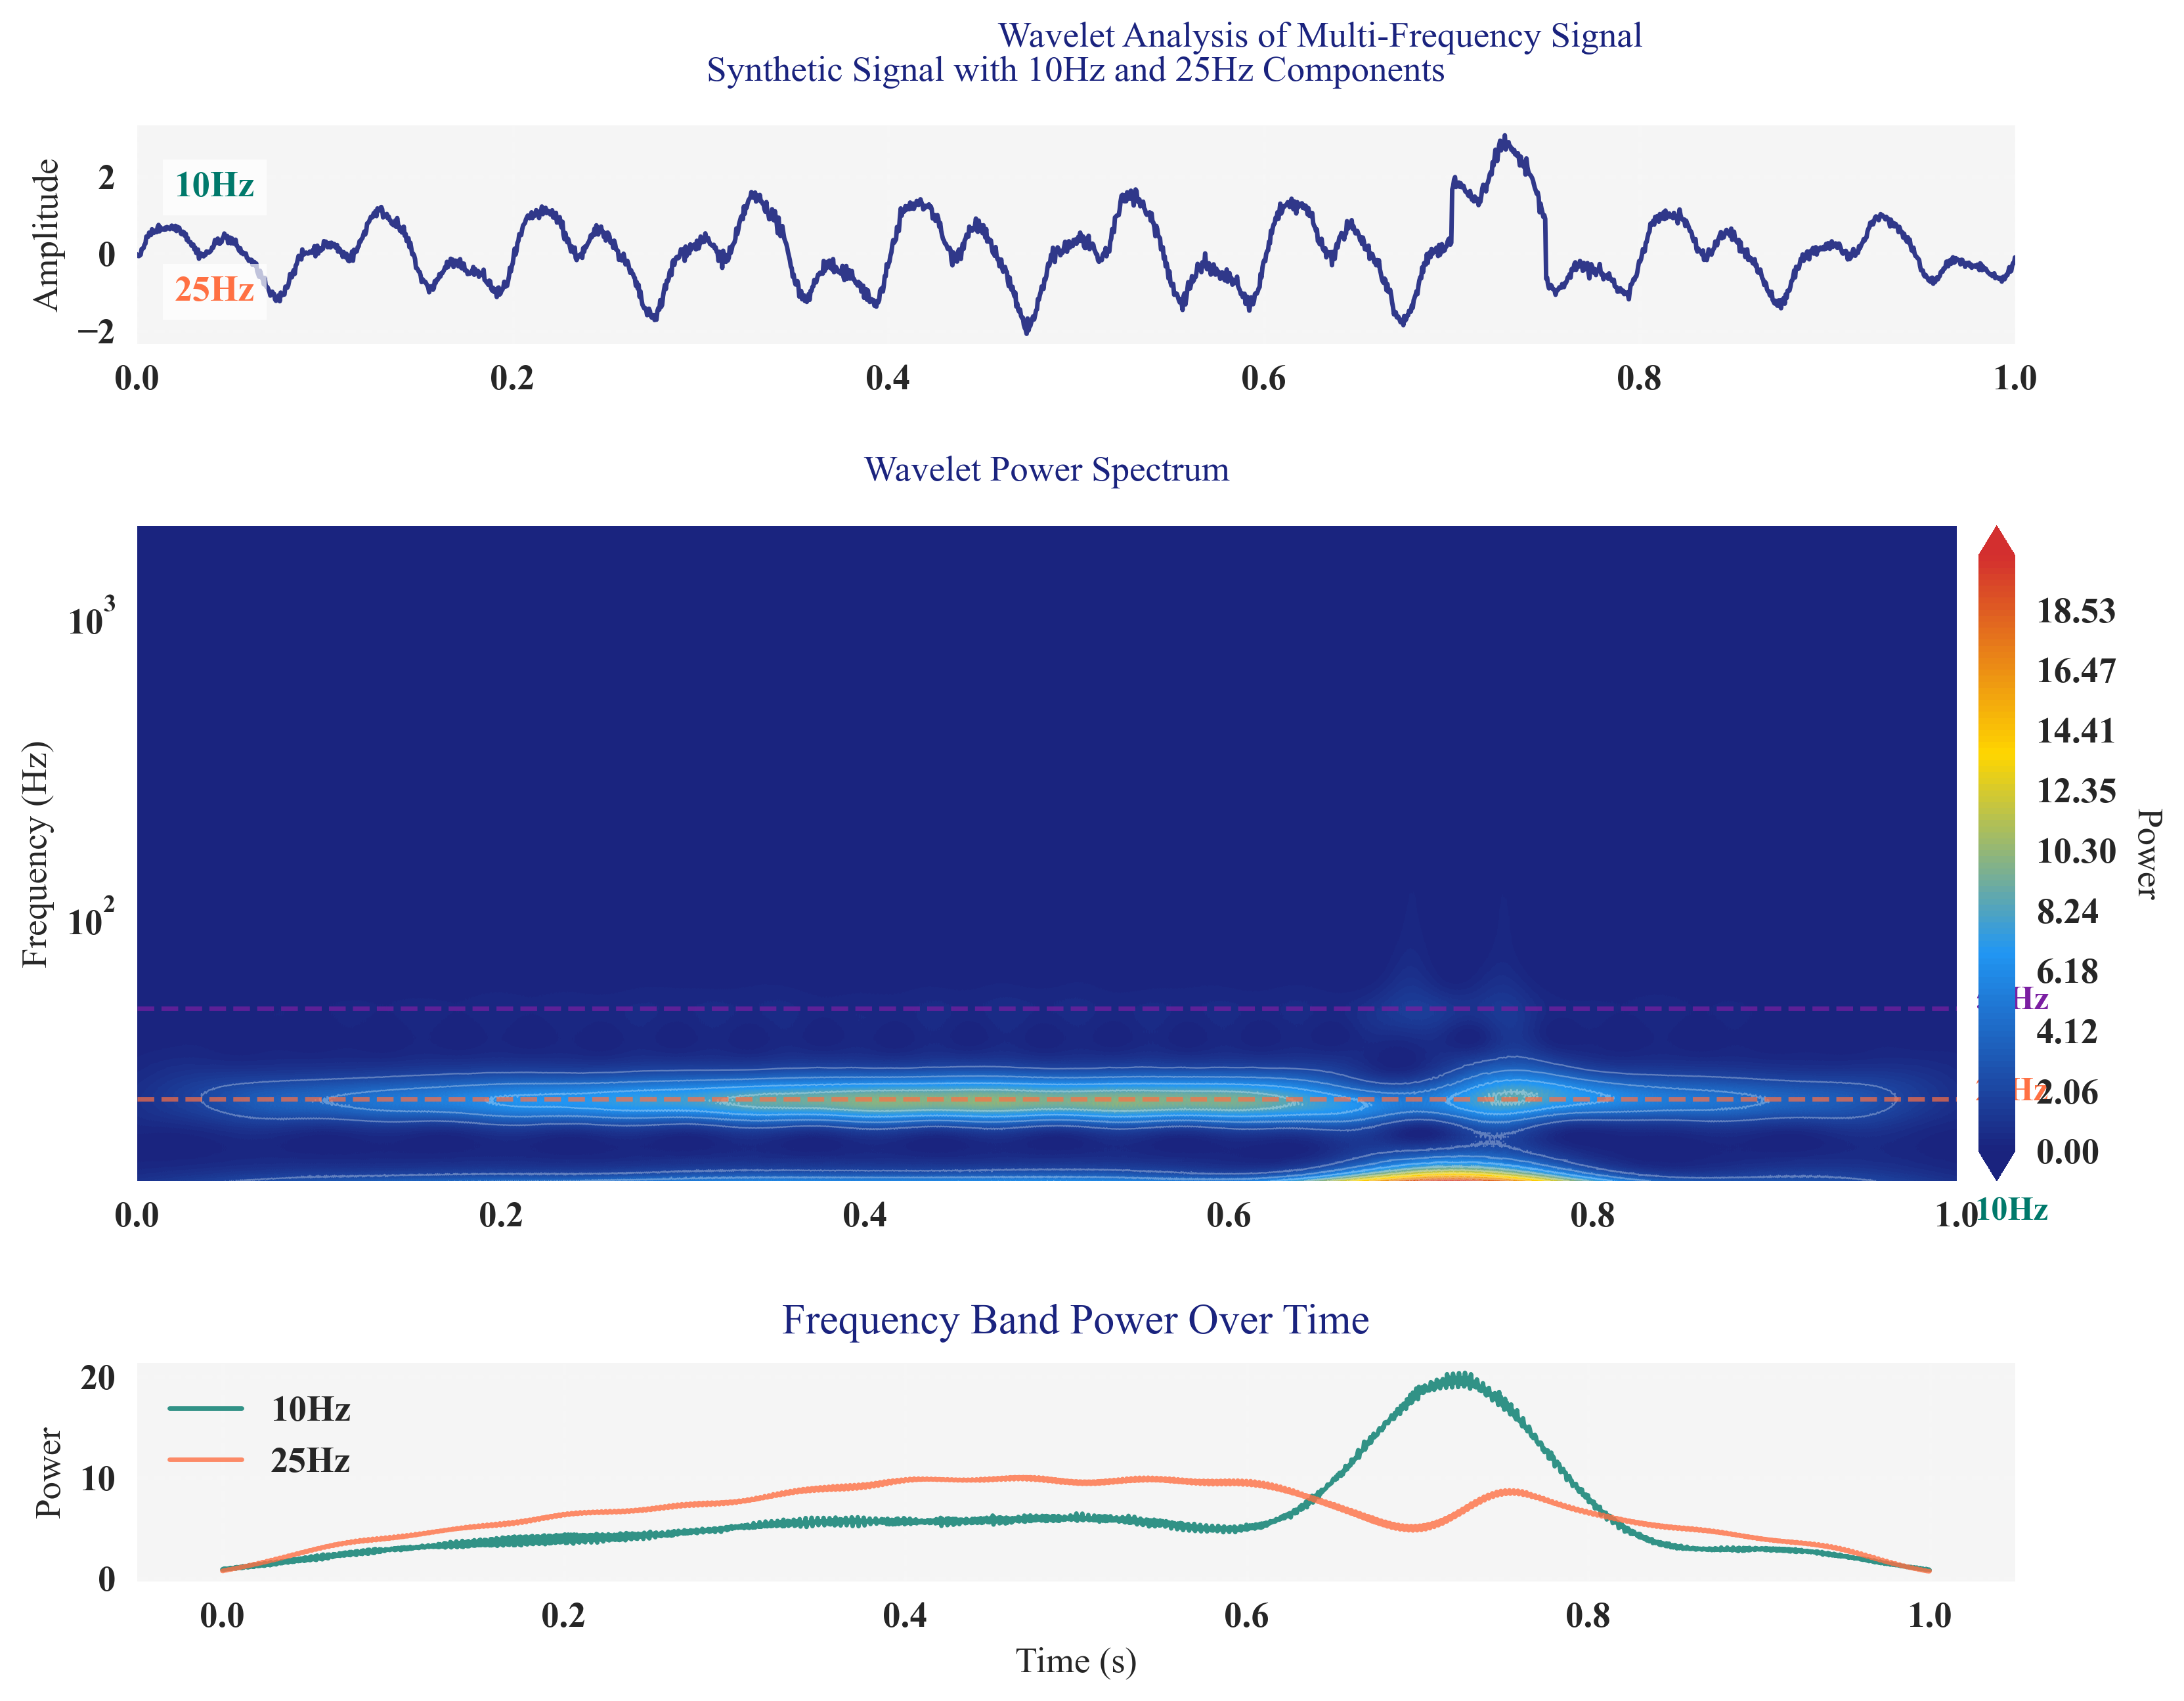

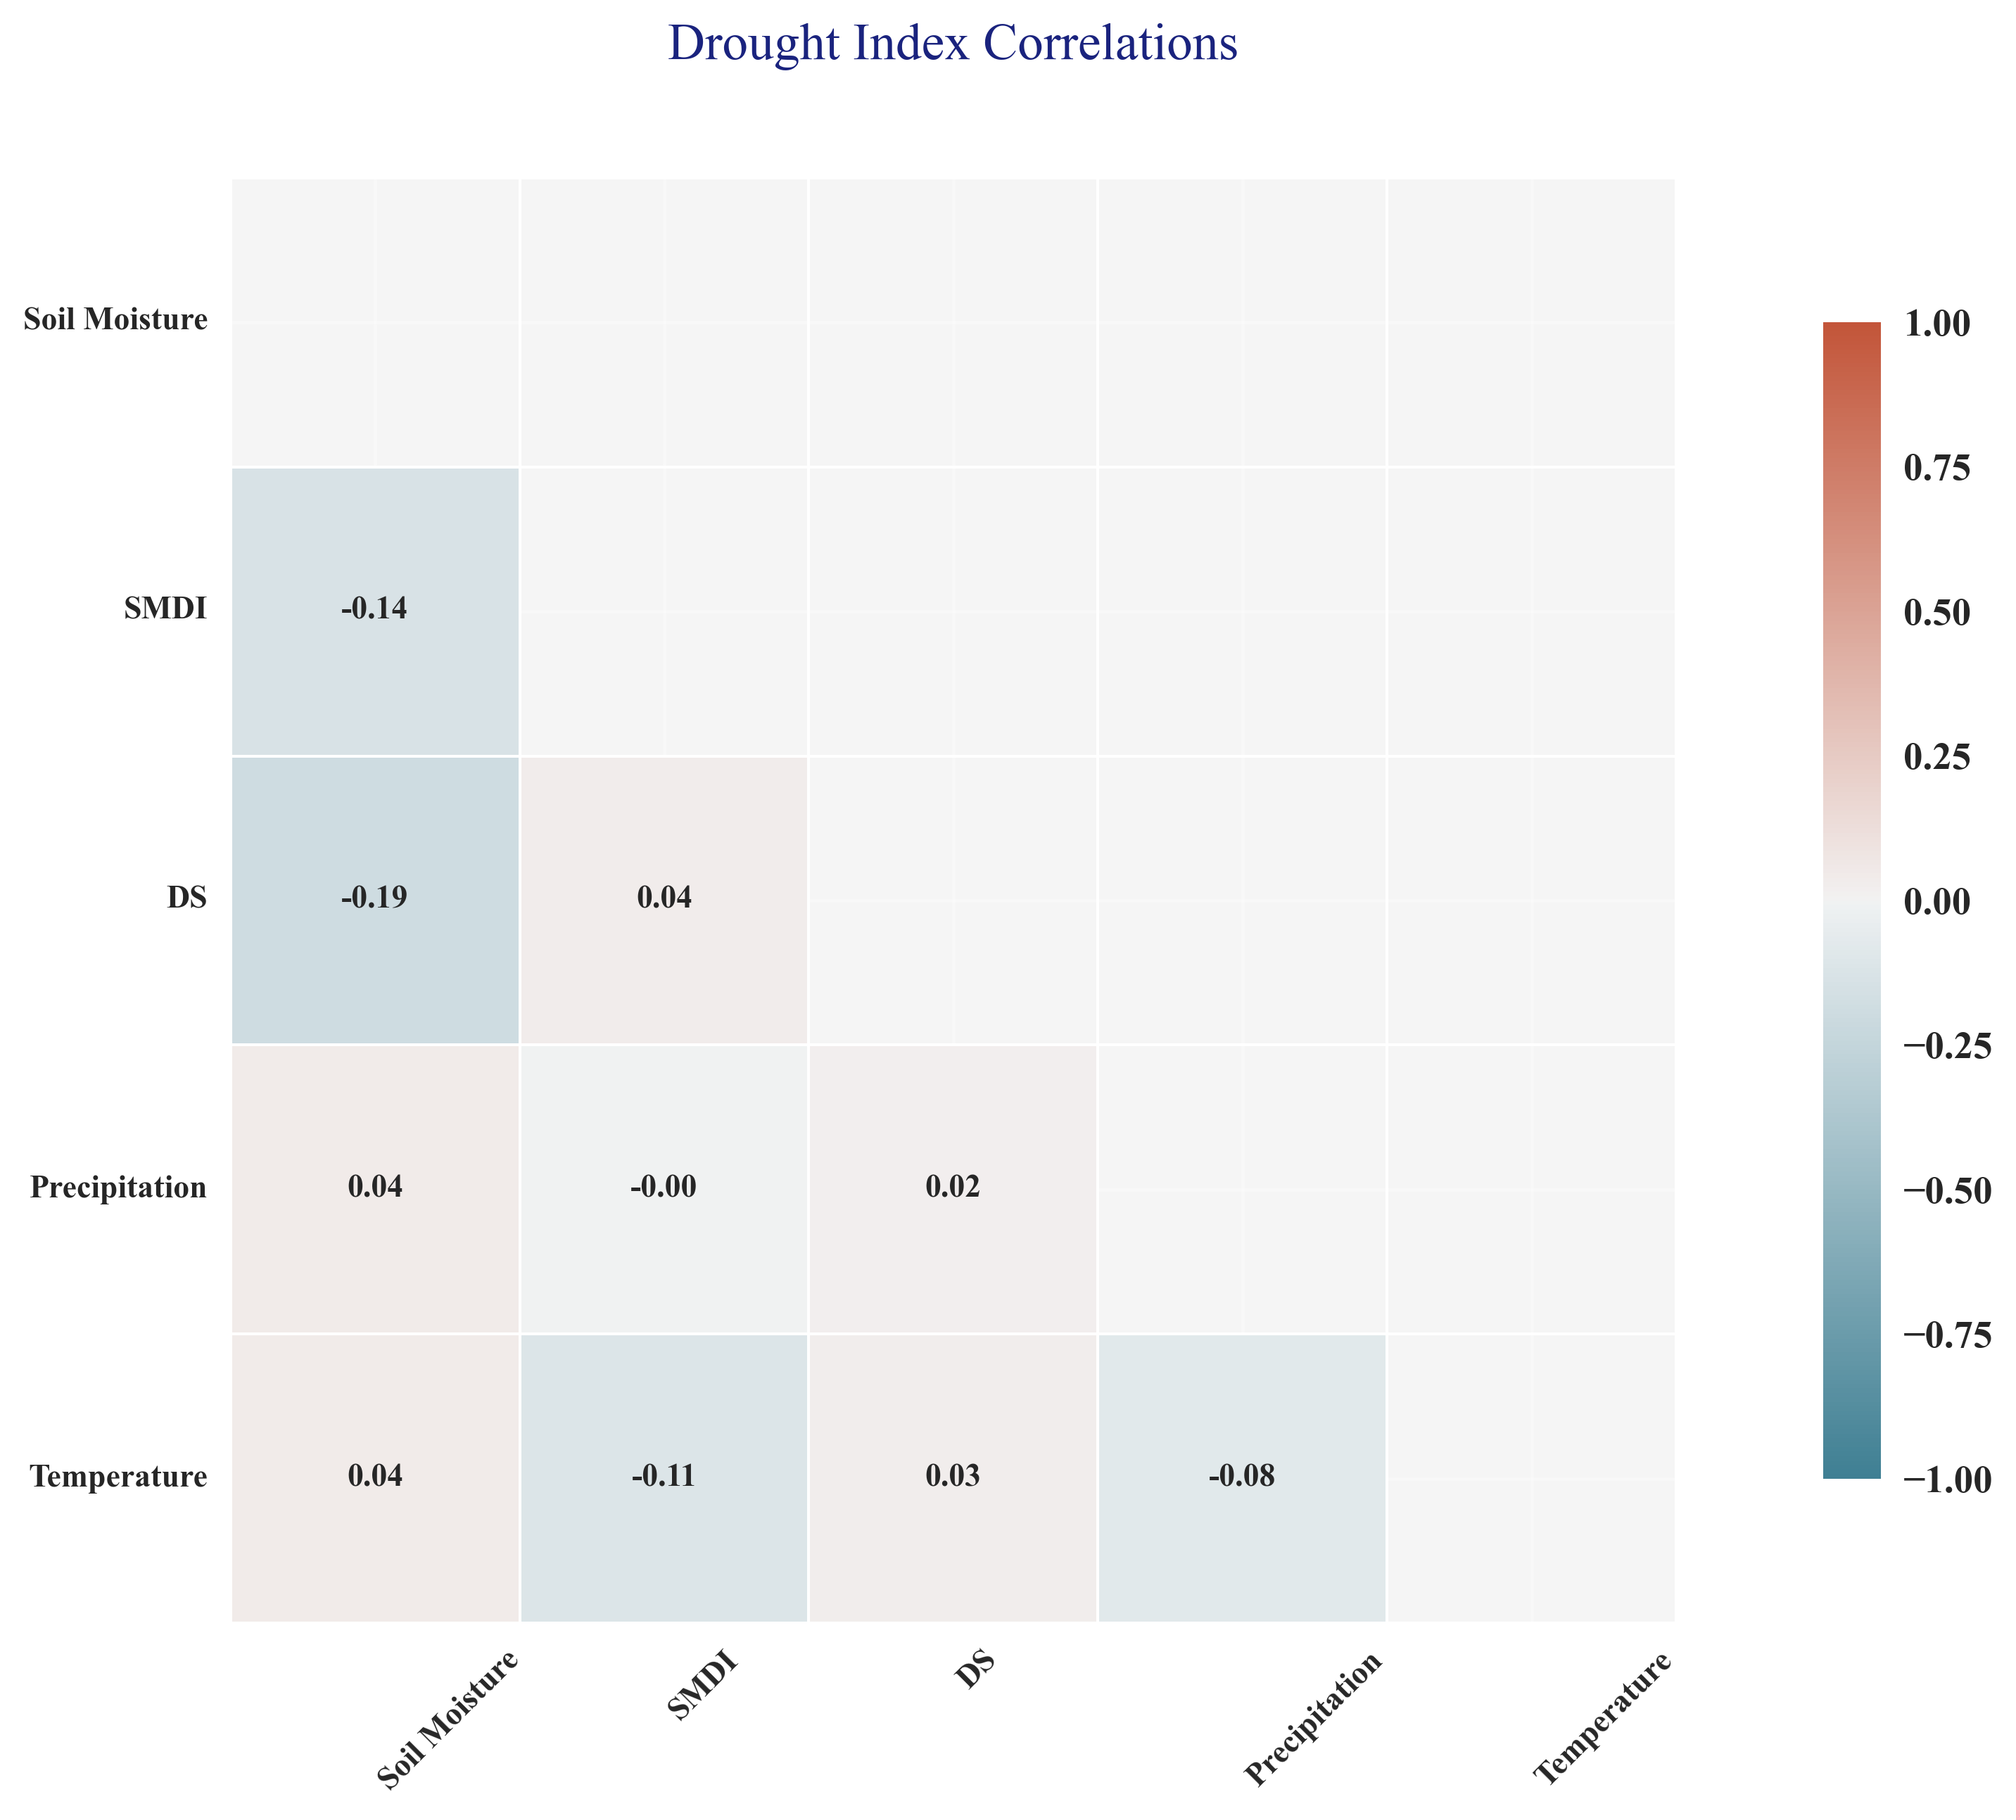

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import warnings
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Suppress warnings
warnings.filterwarnings('ignore')

# Custom color palette
PALETTE = {
    'deep_blue': '#1a237e',
    'ocean_blue': '#1565c0',
    'sky_blue': '#2196f3',
    'teal': '#00897b',
    'emerald': '#00796b',
    'gold': '#ffd600',
    'orange': '#fb8c00',
    'coral': '#ff7043',
    'crimson': '#d32f2f',
    'purple': '#7b1fa2'
}

# Create custom colormap
wavelet_cmap = LinearSegmentedColormap.from_list(
    'wavelet_cmap', 
    [PALETTE['deep_blue'], PALETTE['sky_blue'], 
     PALETTE['gold'], PALETTE['crimson']]
)

# Set global style
plt.style.use('seaborn-v0_8')
plt.rcParams.update({
  'font.family': 'Times New Roman',
    'font.size': 12,
    'axes.titlesize': 12,
    'axes.labelsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 12,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'axes.facecolor': '#f5f5f5',
    'figure.facecolor': 'white',
    'figure.dpi': 330
})

def create_synthetic_signal():
    """Generate a beautiful synthetic signal with known frequencies"""
    t = np.linspace(0, 1, 2000)
    
    # Main components
    signal = (1.0 * np.sin(2*np.pi*10*t) +        # 10 Hz component
             0.7 * np.sin(2*np.pi*25*t - 0.5) +   # 25 Hz component with phase shift
             0.2 * np.sin(2*np.pi*50*t) +         # 50 Hz harmonic
             0.1 * np.random.randn(len(t)))       # Noise
    
    # Add an amplitude modulation
    signal *= 0.5 + 0.5 * np.sin(2*np.pi*0.5*t)
    
    # Add a transient event
    signal[int(len(t)*0.7):int(len(t)*0.75)] += 1.5 * np.exp(-50*(t[int(len(t)*0.7):int(len(t)*0.75)]-0.7)**2)
    
    return t, signal

def plot_wavelet_analysis():
    """Create a publication-quality wavelet analysis visualization"""
    t, signal = create_synthetic_signal()
    sampling_freq = 2000  # 2 kHz sampling rate
    
    # Perform wavelet transform
    scales = np.arange(1, 151)
    freqs = pywt.scale2frequency('cmor1.5-1.0', scales) * sampling_freq
    coefs, _ = pywt.cwt(signal, scales, 'cmor1.5-1.0', sampling_period=1/sampling_freq)
    power = np.abs(coefs)**2
    
    # Create figure
    fig = plt.figure(figsize=(13, 8), facecolor='white')
    gs = fig.add_gridspec(3, 2, width_ratios=[5,1], height_ratios=[1,3,1],
                         left=0.08, right=0.92, bottom=0.08, top=0.92,
                         hspace=0.5, wspace=0.1)
    
    # 1. Time series plot
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(t, signal, color=PALETTE['deep_blue'], linewidth=1.5, alpha=0.9)
    ax1.set_title('Synthetic Signal with 10Hz and 25Hz Components', 
                 fontsize=12, pad=15, color=PALETTE['deep_blue'])
    ax1.set_ylabel('Amplitude', fontsize=12)
    ax1.set_xlim(t[0], t[-1])
    ax1.grid(True, alpha=0.2, linestyle='--')
    
    # Highlight components
    ax1.text(0.02, 1.5, '10Hz', color=PALETTE['emerald'], fontsize=12, 
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    ax1.text(0.02, -1.2, '25Hz', color=PALETTE['coral'], fontsize=12,
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # 2. Wavelet power spectrum
    ax2 = fig.add_subplot(gs[1, 0])
    levels = np.linspace(0, power.max(), 100)
    contour = ax2.contourf(t, freqs, power, levels=levels, 
                          cmap=wavelet_cmap, extend='both')
    
    # Add contour lines
    CS = ax2.contour(t, freqs, power, levels=levels[::10], 
                    colors='white', linewidths=0.5, alpha=0.3)
    
    ax2.set_yscale('log')
    ax2.set_ylim(freqs.min(), freqs.max())
    ax2.set_title('Wavelet Power Spectrum', fontsize=12, pad=15, 
                 color=PALETTE['deep_blue'])
    ax2.set_ylabel('Frequency (Hz)', fontsize=12)
    
    # Mark the known frequencies
    for freq, color in [(10, PALETTE['emerald']), (25, PALETTE['coral']), (50, PALETTE['purple'])]:
        ax2.axhline(freq, color=color, linestyle='--', linewidth=1.5, alpha=0.7)
        ax2.text(t[-1]*1.01, freq*1.05, f'{freq}Hz', color=color, 
                fontsize=11, va='center', ha='left')
    
    # Add colorbar
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    cbar = fig.colorbar(contour, cax=cax)
    cbar.set_label('Power', rotation=270, labelpad=15, fontsize=12)
    
    # # 3. Global wavelet spectrum
    # ax3 = fig.add_subplot(gs[1, 1])
    # global_ws = power.mean(axis=1)
    # ax3.plot(global_ws, freqs, color=PALETTE['crimson'], linewidth=2)
    # ax3.set_yscale('log')
    # ax3.set_title('Global Spectrum', fontsize=12, pad=10, 
    #              color=PALETTE['deep_blue'])
    # ax3.set_xlabel('Power', fontsize=10)
    # ax3.yaxis.tick_right()
    # ax3.yaxis.set_label_position("right")
    # ax3.grid(True, alpha=0.2, linestyle='--')
    
    # # # Mark peaks
    # # for freq, color in [(10, PALETTE['emerald']), (25, PALETTE['coral']), (50, PALETTE['purple'])]:
    # #     idx = np.argmin(np.abs(freqs - freq))
    # #     ax3.plot(global_ws[idx], freqs[idx], 'o', color=color, markersize=8)
    # #     ax3.text(global_ws[idx]*1.1, freqs[idx]*1.05, f'{freq}Hz', 
    # #             color=color, fontsize=10)
    
    # 4. Time slices at specific frequencies
    ax4 = fig.add_subplot(gs[2, 0])
    for freq, color in [(10, PALETTE['emerald']), (25, PALETTE['coral'])]:
        idx = np.argmin(np.abs(freqs - freq))
        ax4.plot(t, power[idx,:], color=color, 
                label=f'{freq}Hz', linewidth=1.5, alpha=0.8)
    
    ax4.set_title('Frequency Band Power Over Time', fontsize=14, pad=10,
                 color=PALETTE['deep_blue'])
    ax4.set_xlabel('Time (s)', fontsize=12)
    ax4.set_ylabel('Power', fontsize=12)
    ax4.legend(loc='upper left', framealpha=0.9)
    ax4.grid(True, alpha=0.2, linestyle='--')
    
    # Add figure title
    fig.suptitle('Wavelet Analysis of Multi-Frequency Signal', 
                fontsize=12, y=0.98, color=PALETTE['deep_blue'])
    
    plt.savefig('beautiful_wavelet_analysis.png', dpi=330, bbox_inches='tight')
    plt.close()
    print("Created beautiful wavelet visualization: beautiful_wavelet_analysis.png")

def create_correlation_heatmap():
    """Create a stylish correlation heatmap"""
    # Generate sample data
    np.random.seed(42)
    data = pd.DataFrame({
        'Soil Moisture': np.random.normal(0, 1, 100),
        'SMDI': np.random.normal(0, 1, 100) * 0.8 + 0.2,
        'DS': np.random.normal(0, 1, 100) * -0.7 + 0.3,
        'Precipitation': np.random.gamma(1, 2, 100),
        'Temperature': np.random.normal(25, 5, 100)
    })
    
    corr = data.corr()
    
    # Create mask for upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))
    
    # Create figure
    plt.figure(figsize=(13, 8))
    
    # Custom diverging colormap
    cmap = sns.diverging_palette(220, 20, as_cmap=True)
    
    # Draw heatmap
    sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8},
                annot=True, fmt=".2f", annot_kws={"size": 10})
    
    # Improve layout
    plt.title('Drought Index Correlations\n', fontsize=16, pad=20, 
             color=PALETTE['deep_blue'])
    plt.xticks(rotation=45, ha='left', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)
    
    plt.tight_layout()
    plt.savefig('beautiful_correlation_heatmap.png', dpi=330, bbox_inches='tight')
    plt.close()
    print("Created beautiful correlation heatmap: beautiful_correlation_heatmap.png")

if __name__ == "__main__":
    print("Creating beautiful visualizations...")
    plot_wavelet_analysis()
    create_correlation_heatmap()
    print("All visualizations created successfully!")

from IPython.display import Image
display(Image(filename='beautiful_wavelet_analysis.png'))
display(Image(filename='beautiful_correlation_heatmap.png'))